# MxNet新前端Gluon模型转换到Symbol
## 1. 导入各种包

In [94]:
from mxnet import gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
from mxnet import autograd as autograd
from mxnet import nd
import mxnet as mx
from collections import namedtuple
import random

## 2. 准备数据
使用和mnist很像的FashionMNIST数据集，使用Gluon下载

In [3]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')

In [4]:
fashion_train = gluon.data.vision.FashionMNIST(root='./',train=True,transform=transform)
fashion_test = gluon.data.vision.FashionMNIST(root='./',train=True, transform=transform)

In [5]:
batch_size = 256
train_data = gluon.data.DataLoader(fashion_train,batch_size,shuffle=True)
test_data = gluon.data.DataLoader(fashion_test,batch_size,shuffle=True)

用于显示图像和标签

In [58]:
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

In [78]:
def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

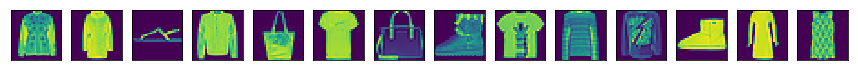

['coat', 'coat', 'sandal', 'coat', 'bag', 't-shirt', 'bag', 'ankle boot', 't-shirt', 'pullover', 'pullover', 'ankle boot', 'dress,', 'dress,']


In [100]:
data,label = fashion_train[5:19]
show_images(data)
print(get_text_labels(label))

## 3. 精度计算函数

In [12]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(nd.transpose(data,(0,3,1,2)))
        acc += accuracy(output, label)
    return acc / len(data_iterator)

## 4. 定义网络
### 4.1 自己定义的层
Gluon模型转到Symbol下只能用`HybridSequential`模式，`HybridSequential`是静态图，会对计算有优化，不过`HybridSequential`和`Sequential`可以很方便的转换，确切的就是一行代码的事。同样自定义的网络，要使用`HybridBlock`，和`Block`没有多大区别

In [18]:
class MyDense(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(MyDense,self).__init__(**kwargs)
        with self.name_scope():
            self.dense0 = nn.Dense(256)
            self.dense1 = nn.Dense(10)
    def hybrid_forward(self,F,x):   #  这里要使用hybrid_forward而不是forward，并且多了个参数F
        return self.dense1(F.relu(self.dense0(x)))    #  F的作用就是替代 nd，如果是静态图，就是用 sym，否则使用 nd

### 4.2 使用自定义的层和自带的层组成完整的网络
网络定义和动态图一样，只不过把`Sequential`替换成了`HybridSequential`，在最后使用`hybridize()`会对静态图进行优化

In [30]:
net = nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Flatten())
    net.add(MyDense())
net.initialize(init=mx.init.Xavier())
net.hybridize()
net

HybridSequential(
  (0): Conv2D(20, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(50, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): MyDense(
    (dense0): Dense(256, linear)
    (dense1): Dense(10, linear)
  )
)

## 5. 训练
使用Adam优化算法，训练的速度会快点

In [31]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'Adam', {'learning_rate': 0.008})

In [32]:
for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    test_acc = 0.
    for data, label in train_data:
        data = nd.transpose(data,(0,3,1,2))
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 0.498041, Train acc 0.817226, Test acc 0.865459
Epoch 1. Loss: 0.312128, Train acc 0.884813, Test acc 0.894265
Epoch 2. Loss: 0.274009, Train acc 0.898454, Test acc 0.898604
Epoch 3. Loss: 0.247741, Train acc 0.906521, Test acc 0.914910
Epoch 4. Loss: 0.226967, Train acc 0.913736, Test acc 0.914334


## 6. 保存成Symbol格式的网络和参数（重点）
要注意保存网络参数的时候，需要`net.collect_params().save()`这样保存，而不是`net.save_params()`保存

In [101]:
net.save_params('Gluon_FashionMNIST.data')  # 将网络参数保存成Gluon模型的格式
x = mx.sym.var('data')                      # 定义输入数据 'data'
y = net(x）                                 # 将sym定义的输入输进网络，获取sym格式的网络
y.save('Gluon_FashionMNIST.json')           # 保存symbol格式的网络
net.collect_params().save('Gluon_FashionMNIST.params')    # 保存网络参数

## 7. 使用Symbol加载网络并绑定

In [ ]:
symnet = mx.symbol.load('Gluon_FashionMNIST.json')
params = nd.load('Gluon_FashionMNIST.params')
mod = mx.mod.Module(symbol=symnet, context=mx.cpu())
mod.bind(data_shapes=[('data', (1, 1, 28, 28))])
mod.set_params(arg_params=params,aux_params={})
Batch = namedtuple('Batch', ['data'])

## 8. 预测试试看效果

In [97]:
img,label = fashion_test[random.randint(0, 60000)]
data = img.transpose([2,0,1])
data = data.reshape([1,1,28,28])

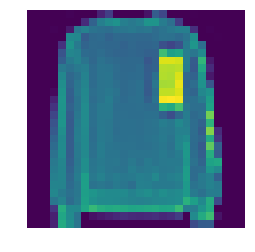

predicted labels: ['pullover']
true labels: ['pullover']


In [98]:
mod.forward(Batch([data]))
out = mod.get_outputs()
prob = out[0]
predicted_labels = prob.argmax(axis=1)

plt.imshow(img.reshape((28, 28)).asnumpy())
plt.axis('off')
plt.show()
print('predicted labels:',get_text_labels(predicted_labels.asnumpy()))

print('true labels:',get_text_labels([label]))